# Experimental Design with Transformations

This notebook checks whether the utility is really independent of linear transformations.
It is made succinct and readable because most detailed code resides in the `compton` package.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from os import path
import seaborn as sns
from matplotlib import gridspec as gs
from sklearn.utils.extmath import cartesian

from compton import create_observable_set, pol_vec_trans_tex_names
from compton import proton_pol_vec_mean, proton_pol_vec_std
from compton import neutron_pol_vec_mean, neutron_pol_vec_std
from compton import proton_pol_vec_trans_std, proton_pol_vec_trans_mean
from compton import neutron_pol_vec_trans_std, neutron_pol_vec_trans_mean

from compton import plot_subsets, compute_all_1pt_utilities, compute_max_utilities
from compton import convert_max_utilities_to_dataframe, convert_max_utilities_to_flat_dataframe
from compton import ComptonExperiment

Set up global plot settings.

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='png')
mpl.rcParams['figure.dpi'] = 150

These colors will be used throughout

In [3]:
proton_cmap = plt.get_cmap('Reds')
neutron_cmap = plt.get_cmap('Blues')
proton_color = proton_cmap(0.55)
neutron_color = neutron_cmap(0.55)

## Read in Data

Start by reading in raw data, and then get it into a form that is more readable.

In [4]:
obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df = pd.read_csv(obs_file, dtype={'observable': str})

In [5]:
omega_lab_unique = df['omegalab [MeV]'].unique()
degrees_lab_unique = df['thetalab [deg]'].unique()
n_omega = len(omega_lab_unique)
n_angle = len(degrees_lab_unique)

In [6]:
X = cartesian([omega_lab_unique, degrees_lab_unique])
X

array([[  5.,   1.],
       [  5.,   5.],
       [  5.,  10.],
       ...,
       [340., 170.],
       [340., 175.],
       [340., 180.]])

For most of the study, using *all* of these kinematic points is overkill, downsample to a more reasonable number within the reach of experiments.

In [7]:
observables_unique_raw = df['observable'].unique()
observables_unique_raw
observables_unique_raw[0] = 'dsg'

In [8]:
observables_unique_raw

array(['dsg', '1X', '1Z', '2X', '2Z', '3', 'Y', '3Y', '3Yp', '1Xp', '1Zp',
       '2Xp', '2Zp'], dtype=object)

In [9]:
observables_name_map = {
    'crosssection': r'$\sigma$',
    '1X': r'$\Sigma_{1x}$',
    '1Z': r'$\Sigma_{1z}$',
    '2X': r'$\Sigma_{2x}$',
    '2Z': r'$\Sigma_{2z}$',
    '3': r'$\Sigma_{3}$',
    'Y': r'$\Sigma_{y}$',
    '3Y': r'$\Sigma_{3y}$',
    '3Yp': r"$\Sigma_{3y'}$",
    '1Xp': r"$\Sigma_{1x'}$",
    '1Zp': r"$\Sigma_{1z'}$",
    '2Xp': r"$\Sigma_{2x'}$",
    '2Zp': r"$\Sigma_{2z'}$",
}

In [10]:
df['observable'] = df['observable'].replace(observables_name_map)
observables_unique = df['observable'].unique()

Observables are constructed as (ratios of) $A + B^T \vec{a} + \vec{a}^T C \vec{a}$, for the polarizabilities $\vec{a}$.

In [11]:
df

,omegalab [MeV],thetalab [deg],observable,nucleon,order,is_numerator,A,B1,B2,B3,...,C33,C34,C35,C36,C44,C45,C46,C55,C56,C66
0,5.0,1,$\sigma$,proton,3,1,23.550624,-0.001971,-0.001971,4.278199e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.0,1,$\sigma$,proton,3,0,1.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5.0,5,$\sigma$,proton,3,1,23.463893,-0.001963,-0.001963,4.271897e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5.0,5,$\sigma$,proton,3,0,1.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.0,10,$\sigma$,proton,3,1,23.195600,-0.001941,-0.001941,4.251508e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284747,340.0,170,$\Sigma_{2z'}$,neutron,4,0,1539.171610,22.347716,-22.350937,4.854397e+01,...,1.775510,-3.452411,3.354500,-3.452411,1.775510,-3.452411,3.354500,1.726380,-3.355539,1.726380
284748,340.0,175,$\Sigma_{2z'}$,neutron,4,1,1404.223925,36.547947,-36.547947,2.941353e+01,...,0.006110,0.012220,-0.012198,-0.012198,0.006110,-0.012198,-0.012198,0.006088,0.012177,0.006088
284749,340.0,175,$\Sigma_{2z'}$,neutron,4,0,1535.901865,22.339037,-22.339236,4.810882e+01,...,1.735146,-3.445853,3.421456,-3.445853,1.735146,-3.445853,3.421456,1.722937,-3.421521,1.722937
284750,340.0,180,$\Sigma_{2z'}$,neutron,4,1,1402.767299,36.552870,-36.552870,2.930796e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
df[['omegalab [MeV]', 'thetalab [deg]']]

,omegalab [MeV],thetalab [deg]
0,5.0,1
1,5.0,1
2,5.0,5
3,5.0,5
4,5.0,10
...,...,...
284747,340.0,170
284748,340.0,175
284749,340.0,175
284750,340.0,180


## Transform to a more natural basis

We must make the transformation
\begin{align*}
\vec{\xi} \to \vec{\xi}' \equiv P \vec{\xi}
\end{align*}
that is
\begin{align*}
\begin{bmatrix}
\alpha + \beta \\
\alpha - \beta \\
\gamma_0 \\
\gamma_\pi \\
\gamma_{E-} \\
\gamma_{M-}
\end{bmatrix}
\equiv
\begin{bmatrix}
    1 &  1 &  0 &  0 &  0 &  0 \\
    1 & -1 &  0 &  0 &  0 &  0 \\
    0 &  0 & -1 & -1 & -1 & -1 \\
    0 &  0 & -1 &  1 & -1 &  1 \\
    0 &  0 &  1 &  0 & -1 &  0 \\
    0 &  0 &  0 &  1 &  0 & -1
\end{bmatrix}
\begin{bmatrix}
\alpha \\ \beta \\ \gamma_{E1E1} \\ \gamma_{M1M1} \\ \gamma_{E1M2} \\ \gamma_{M1E2}
\end{bmatrix}
\end{align*}

This is not an orthogonal transformation but for the new utility formula this is not a problem. So everything is good!

In [13]:
P = np.array([
    [1,  1,  0,  0,  0,  0],
    [1, -1,  0,  0,  0,  0],
    [0,  0, -1, -1, -1, -1],
    [0,  0, -1,  1, -1,  1],
    [0,  0,  1,  0, -1,  0],
    [0,  0,  0,  1,  0, -1]
])
P_inv = np.linalg.inv(P)

In [14]:
cov_p_proton = np.diag(proton_pol_vec_std)
cov_p_proton_mapped = P @ cov_p_proton @ P.T

cov_p_neutron = np.diag(neutron_pol_vec_std)
cov_p_neutron_mapped = P @ cov_p_neutron @ P.T

In [27]:
sd_exp = 0.05  # Guess from fig A.9 from Martel Thesis

Make two compton observable sets. One of which uses transformed parameters and the other does not.

In [28]:
compton_obs = create_observable_set(df=df, cov_exp=sd_exp**2, cov_p_proton=cov_p_proton, cov_p_neutron=cov_p_neutron)
compton_obs_mapped = create_observable_set(
    df=df, cov_exp=sd_exp**2, p_transform=P,
    cov_p_proton=cov_p_proton_mapped, cov_p_neutron=cov_p_neutron_mapped
)

## Checking if the utility is invariant under change of polarizations

hint: it is!

In [29]:
np.linalg.det(cov_p_proton)

0.11240901846048648

In [30]:
np.linalg.det(cov_p_proton_mapped)

28.776708725884532

From each observable, compute the expected utilities

In [31]:
utils_no_trans = compute_all_1pt_utilities(compton_obs)

In [32]:
utils_with_trans = compute_all_1pt_utilities(compton_obs_mapped)

Plot the utilities next to each other.

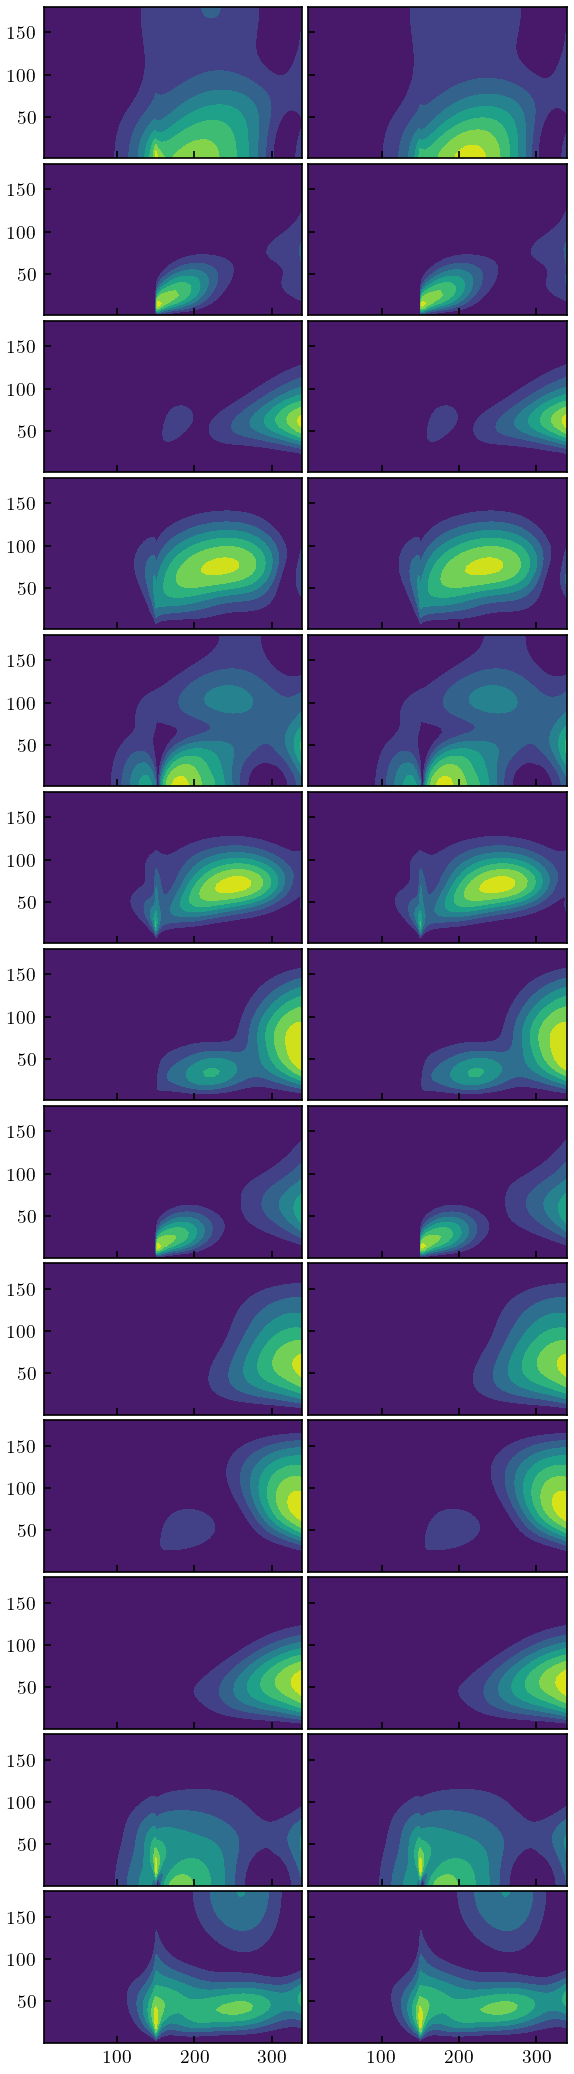

In [33]:
fig, axes = plt.subplots(len(observables_unique), 2, figsize=(4, 14), sharex=True, sharey=True)
for i, obs_i in enumerate(observables_unique):
    for j, nucleon_j in enumerate(['proton']):
        ax = axes[i, j]
        order_i = 4

        util_i = utils_no_trans[nucleon_j, obs_i, 'all']
        util_i_mapped = utils_with_trans[nucleon_j, obs_i, 'all']

        axes[i, 0].contourf(omega_lab_unique, degrees_lab_unique, util_i.reshape(n_omega, n_angle).T)
        axes[i, 1].contourf(omega_lab_unique, degrees_lab_unique, util_i_mapped.reshape(n_omega, n_angle).T)
        axes[i, 0].tick_params(direction='in')
        axes[i, 1].tick_params(direction='in')
fig.tight_layout(h_pad=0.3, w_pad=0.3)